# Carga de librerías y datos

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

CUSTOM_FORMAT = {"with_labels" : False,
                "node_size": 20, "node_color": "#ff0000", "edgecolors": "#911a07",
                "width": 0.4, "edge_color": "black"}

dolphins = nx.read_gml("datasets/dolphins.txt")
genders = pd.read_csv("datasets/dolphinsGender.txt", delimiter = "\t", header = None, names = ["ID", "Gender"])

In [2]:
genders.set_index("ID", inplace = True)
genders = pd.Series(genders["Gender"])

#Agregamos el atributo de sexo a cada nodo
for i in dolphins.nodes: 
    dolphins.nodes[i]["Gender"] = genders[i]
#Por lo que ahora podemos acceder al genero de cada delfin como dolphins.nodes[ID]["Gender"]

# A) Visualización de la red

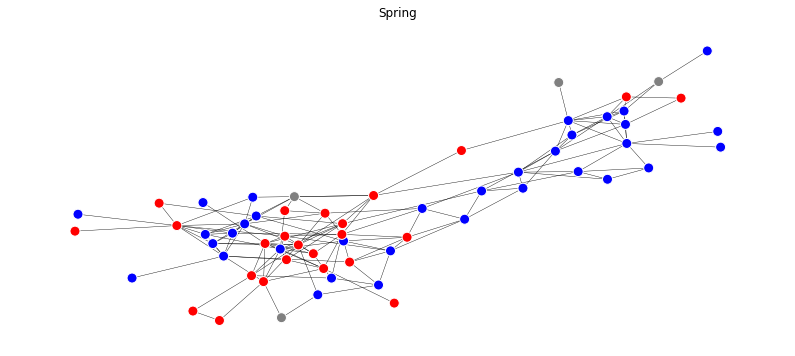

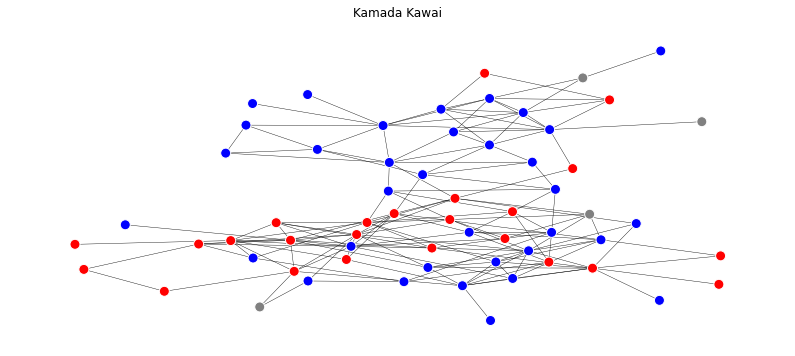

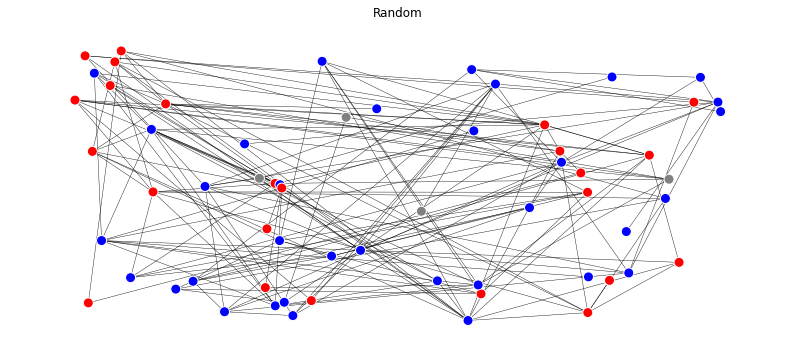

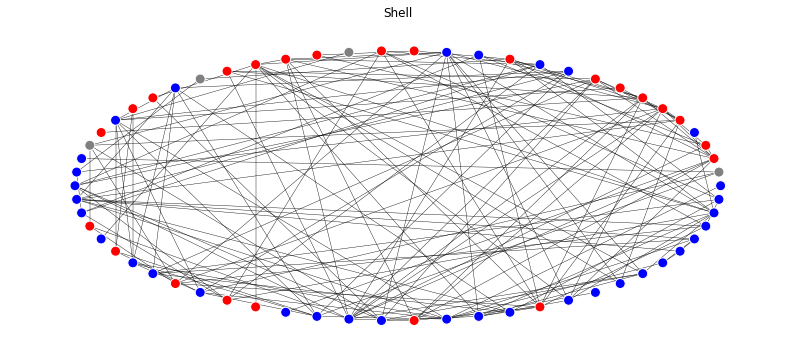

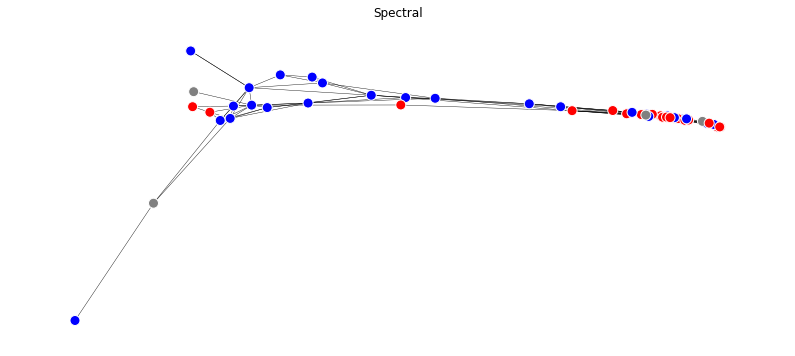

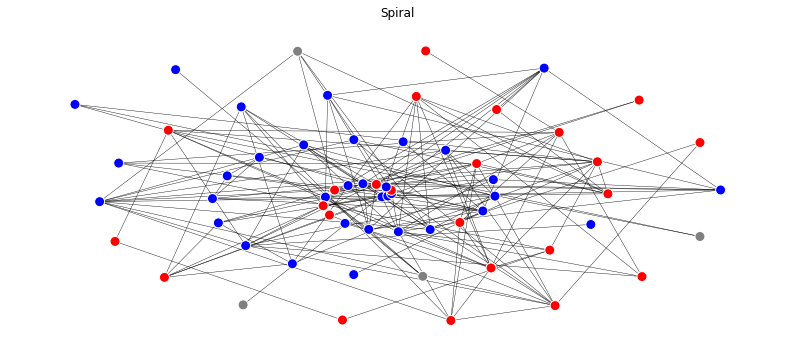

In [3]:
def layouts(graph):
    return {
     "Spring": nx.layout.spring_layout(graph, seed=42),
     "Kamada Kawai": nx.layout.kamada_kawai_layout(graph),
     "Random": nx.layout.random_layout(graph, seed=42),
     "Shell": nx.layout.shell_layout(graph),
     "Spectral": nx.layout.spectral_layout(graph),
     "Spiral": nx.layout.spiral_layout(graph)
    }

for k, l in layouts(dolphins).items():
    fig, ax = plt.subplots(1, 1, figsize = (14, 6))
    nx.draw(
            dolphins, 
            with_labels = False, 
            node_size = 100, 
            edgecolors = "white",
            width = 0.4, 
            node_color = ["red" if dolphins.nodes[node]["Gender"] == "f" 
                          else ("blue" if dolphins.nodes[node]["Gender"] == "m" else "gray") 
                          for node in dolphins.nodes],
            pos = l)
    ax.set_title(k)
    plt.show()

# B) i) Calculo de homofilia y comparación con distribuciones aleatorias

In [4]:
def get_homophily(series, graph):
    homo_edges = [series.loc[i[0]] == series.loc[i[1]] for i in graph.edges]
    homophily = sum(homo_edges)/len(homo_edges)
    return homophily

def shuffle_series(series: pd.Series, seed: int = 42) -> pd.Series:
    """
    Shuffle a given series.
    """
    idx = series.index
    series_mod = series.sample(frac=1.0, random_state= seed, )
    series_mod.index = idx
    return series_mod

In [5]:
#Conseguimos la homofilia de la red original.
homophily = get_homophily(genders, dolphins)

In [15]:
h = []
try:
    h = np.load("50000 iters.npy")
except FileNotFoundError:
    for s in tqdm(range(0, 50000)): #Conseguimos la homofilia de 1000 distribuciones aleatorias de generos.
        #Mezclamos los generos y copiamos la red para no transformarla.
        shuffled_genders = shuffle_series(genders, seed=s)
        dolphins_copy = dolphins.copy()

        #Cambiamos los generos de la copia de dolphins con los mezclados.
        for i in dolphins_copy.nodes: 
            dolphins_copy.nodes[i]["Gender"] = shuffled_genders[i]

        #Calculamos la homofilia para la red mezclada.
        h.append(get_homophily(shuffled_genders, dolphins_copy))
    h = np.array(h)
    np.save("50000 iters.npy", h)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:02<00:00, 273.94it/s]


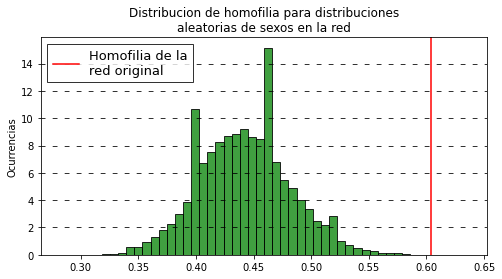

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(h, color="green", stat="density", bins = 50)
plt.title("Distribucion de homofilia para distribuciones\naleatorias de sexos en la red")
plt.ylabel("Ocurrencias")
plt.grid(axis="y", linestyle=(1, (6, 9)), color="black")
plt.axvline(homophily, color="red", label="Homofilia de la\nred original")
plt.legend(fancybox=False, edgecolor="black", fontsize=13)
plt.show()